In [1046]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.auto import trange
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score

In [1047]:
def display_table(table, row_labels, col_labels):
    html = "<table>"
    html += "<tr><th></th><th>" + "</th><th>".join(col_labels) + "</th></tr>"
    for i, row in enumerate(table):
        html += "<tr><th>" + row_labels[i] + "</th><td>" + "</td><td>".join(map(str, row)) + "</td></tr>"
    html += "</table>"
    display(HTML(html))

def safelog(vals):
    with np.errstate(divide='ignore'):
        return np.log(vals)

#### 2. Open lexicon model 


In [1048]:
class Agent:
    def __init__(self, n_words, n_meanings, costs=None, prior=None, alpha=1):
        self.lexicons = self.all_binary_arrays(n_words*n_meanings, n_words, n_meanings)
        self.lexicons_norm = np.array([self.normalize(lexicon) for lexicon in self.lexicons])
        self.lexicon_probs = np.ones(len(self.lexicons)) / len(self.lexicons)
        self.alpha = alpha
        # self.costs are uniform over the number of words
        if costs is not None:
            self.costs = costs
        else:
            self.costs = np.zeros(n_words)
        if prior is not None:
            self.prior = self.normalize(prior)
        else:
            self.prior = np.ones(n_meanings) / n_meanings

    @staticmethod
    def normalize(A):
        # if only one dimension do not transpose
        if len(A.shape) == 1:
            return A / A.sum()
        with np.errstate(divide='ignore'):
            return np.nan_to_num((A.T / A.sum(axis=1)).T)

    @staticmethod
    def all_binary_arrays(n, n_words, n_meanings):
        '''
        Generate all possible lexicons of size n
        and remove the lexicons with no at least one word 
        per meaning
        '''
        arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) for i in range(2**n)])
        lexicons = arrays.reshape((2**n, n_words, n_meanings))
        # sum by column and remove lexicons with no words per meaning
        return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)

    def l_lit(self, A, context):
        if self.prior is not None:
            return self.normalize(A * self.prior[context])
        else:
            return self.normalize(A * self.prior)

    def s_prag(self, A):
        # literal listener, ts the matrix received from the speaker
        # subtract C rather than add it to keep the values positive
        return self.normalize(np.exp(self.alpha * (safelog(A.T) + self.costs)))

    def l_prag(self, A, context):
        # literal listener, ts the matrix received from the speaker
        if self.prior is not None:
            return self.normalize(A.T * self.prior[context])
        else:
            return self.normalize(A.T * self.prior)

    def speaker(self, meaning, context):
        # randomly sample one of the lexicon given the probabilities
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        L_0 = self.l_lit(lexicon, context)
        return np.argmax(self.s_prag(L_0)[meaning])

    def listener(self, message, int_meaning, context):
        # randomly sample one of the lexicon given the probabilities
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        L_0 = self.l_lit(lexicon, context)
        S_P = self.s_prag(L_0)
        return np.argmax(self.l_prag(S_P, context)[message])
    
    def update_lexicon(self, message, meaning):
        # for each lexicon, multiply the probability of the message-meanings pair by the probability of the lexicon
        # and normalize
        self.lexicon_probs = self.normalize(self.lexicon_probs * self.lexicons_norm[:, message, meaning]) 
        # * p(meaning|context)
    
    def show_lexicon(self, idx):
        lexicon =  self.lexicons[np.argsort(self.lexicon_probs)[::-1][idx]]
        for _ in range(len(self.prior)):
            L_0 = self.l_lit(lexicon, _)
            S_P = self.s_prag(L_0)
            prag_list = self.l_prag(S_P, _)
            print(f'Context: {_}')
            display_table(np.hstack([np.round(prag_list, 2), self.costs[:, None]]), 
            ["s_1", "s_2"], [f'm_{i}' for i in range(3)] + ["cost"])

In [1049]:
N_MEANINGS = 3
PRIOR = np.array([[1, 1, 0], [1, 0, 1]])
COSTS = np.array([1, 10])
ALPHA = 5
context_meanings = {0: [0, 1], 1: [0], 2: [1]}

posts = []
logs_comp = []

for tr in trange(100):
    # initalize two agents
    agent1 = Agent(n_words = 2, n_meanings = N_MEANINGS, prior = PRIOR, costs = COSTS, alpha = ALPHA)
    agent2 = Agent(n_words = 2, n_meanings = N_MEANINGS, prior = PRIOR, costs = COSTS, alpha = ALPHA)
    # logs 
    logs = defaultdict(dict)
    for _ in range(100):
        # randomly choose 1 or 0
        # sample one integer from 0 to 2
        meaning = np.random.randint(0, N_MEANINGS)
        # sample context given the integer
        context = np.random.choice(context_meanings[meaning])
        logs[_] = {'trial': tr, 'context': context, 'meaning': meaning}
        
        # if iteration is even agent1 speaks, otherwise agent2 speaks
        if _ % 2 == 0:
            message = agent1.speaker(meaning, context)
            meaning_guess = agent2.listener(message, meaning, context)
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
        else:
            message = agent2.speaker(meaning, context)
            meaning_guess = agent1.listener(message, meaning, context)  
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
    logs_comp.append(logs)
    posts.append(agent1.lexicon_probs)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_28642/1612626182.py:23: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


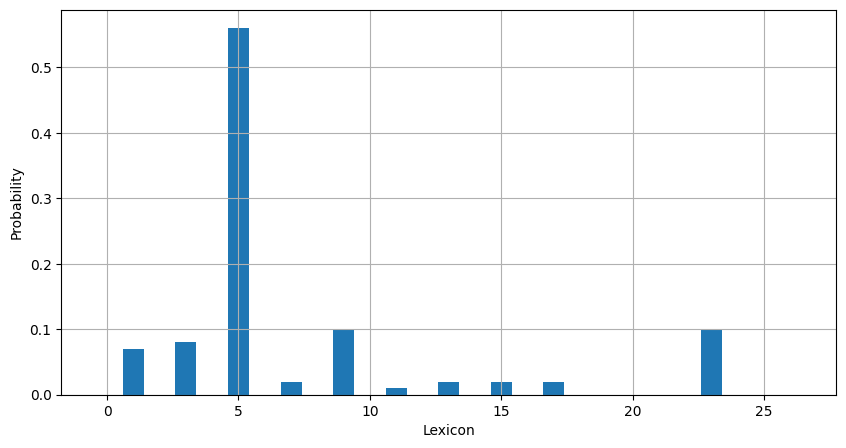

In [1050]:
# sum over posts
lexicon_probs = np.sum(posts, axis=0)
# normalize
lexicon_probs = lexicon_probs / lexicon_probs.sum()

# plot the posterior distribution of the lexicons
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(lexicon_probs)), lexicon_probs)
plt.xlabel('Lexicon')
plt.ylabel('Probability')
plt.grid()

In [1051]:
agent2.show_lexicon(0)

Context: 0


/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_28642/1612626182.py:23: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


,m_0,m_1,m_2,cost
s_1,0.0,1.0,0.0,1.0
s_2,1.0,0.0,0.0,10.0


Context: 1


,m_0,m_1,m_2,cost
s_1,0.0,0.0,1.0,1.0
s_2,1.0,0.0,0.0,10.0


In [1052]:
agent1.show_lexicon(0)

Context: 0


/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_28642/1612626182.py:23: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


,m_0,m_1,m_2,cost
s_1,0.0,1.0,0.0,1.0
s_2,1.0,0.0,0.0,10.0


Context: 1


,m_0,m_1,m_2,cost
s_1,0.0,0.0,1.0,1.0
s_2,1.0,0.0,0.0,10.0


In [1053]:
# display 4 top lexicons
for i in np.argsort(agent1.lexicon_probs)[::-1][:4]:
    print("Lexicon probability: {}".format(agent1.lexicon_probs[i]))
    display_table(np.hstack([agent1.lexicons[i], agent1.costs[:, None]]), ["s_1", "s_2"], [f'm_{i}' for i in range(N_MEANINGS)] + ["cost"])

Lexicon probability: 0.9999999997490376


,m_0,m_1,m_2,cost
s_1,0,1,1,1
s_2,1,0,0,10


Lexicon probability: 1.1641532179771895e-10


,m_0,m_1,m_2,cost
s_1,0,1,1,1
s_2,1,0,1,10


Lexicon probability: 1.1641532179771895e-10


,m_0,m_1,m_2,cost
s_1,0,1,1,1
s_2,1,1,0,10


Lexicon probability: 1.8131477588359145e-11


,m_0,m_1,m_2,cost
s_1,1,1,1,1
s_2,1,0,0,10


In [1054]:
# display 4 top lexicons
for i in np.argsort(agent2.lexicon_probs)[::-1][:4]:
    print("Lexicon probability: {}".format(agent2.lexicon_probs[i]))
    display_table(np.hstack([agent2.lexicons[i], agent2.costs[:, None]]), 
    ["s_1", "s_2"], ["m_1", "m_2", "m_3", "C"])

Lexicon probability: 0.9999999997490376


,m_1,m_2,m_3,C
s_1,0,1,1,1
s_2,1,0,0,10


Lexicon probability: 1.1641532179771895e-10


,m_1,m_2,m_3,C
s_1,0,1,1,1
s_2,1,0,1,10


Lexicon probability: 1.1641532179771895e-10


,m_1,m_2,m_3,C
s_1,0,1,1,1
s_2,1,1,0,10


Lexicon probability: 1.8131477588359145e-11


,m_1,m_2,m_3,C
s_1,1,1,1,1
s_2,1,0,0,10


In [1055]:
logs = pd.DataFrame(logs_comp[15]).T

In [1056]:
logs['cent'] = logs.index // 5 + 1

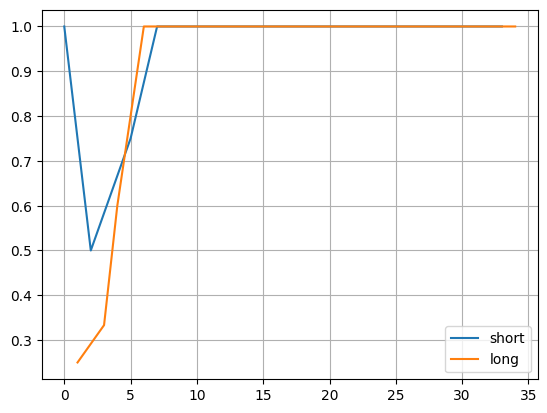

In [1057]:
# group by cent and message
logs_grouped = logs.groupby(['cent', 'message']).mean()
logs_grouped.reset_index(inplace=True)
result = logs_grouped[['cent', 'message', 'correct']]

# plot the accuracy
plt.plot(result[result['message'] == 0]['correct'], label='short')
plt.plot(result[result['message'] == 1]['correct'], label='long')
plt.legend()
plt.grid()

In [1058]:
# rename message as short if 0 and long if 1
logs['message_length'] = logs['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs['meaning'] = logs['meaning'].apply(lambda x: f'm_{x}')

<AxesSubplot: xlabel='meaning', ylabel='Count'>

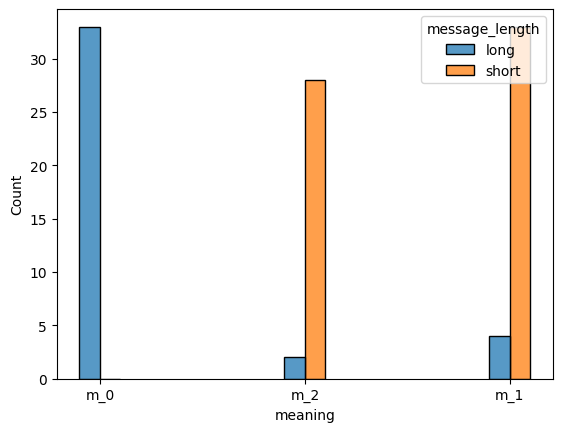

In [1059]:
# plot histogram of meanings and how often short of long messages are used
sns.histplot(data=logs, x='meaning', hue='message_length', multiple='dodge', shrink=.2)

In [1060]:
#### NB: removing first 20 trials ####
logs_comb = pd.concat([pd.DataFrame(k).T[20:] for k in logs_comp]).reset_index(drop=True)

In [1061]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')

<AxesSubplot: xlabel='meaning_s', ylabel='Count'>

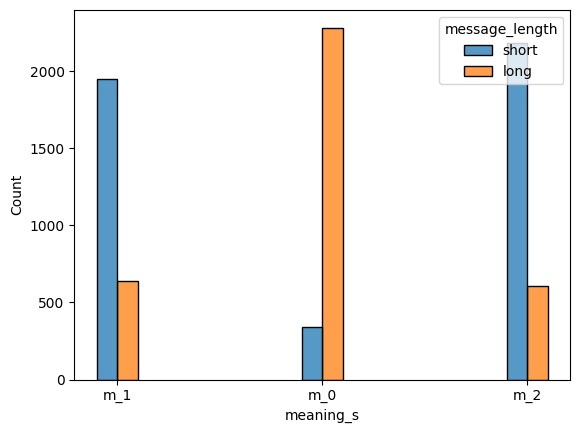

In [1062]:
# plot histogram of meanings and how often short of long messages are used, order x axis by name
sns.histplot(data=logs_comb, x='meaning_s', hue='message_length', multiple='dodge', shrink=.2)

In [1063]:
dfs = [pd.DataFrame(k).T for k in logs_comp]

In [1064]:
results = defaultdict(dict)

for i, df in enumerate(dfs):
    ll_ = normalized_mutual_info_score(df['meaning'], df['meaning_guess'])
    # count percentage of long word being used with meaning 0
    long_0 = df[(df['meaning'] == 0) & (df['message'] == 1)].shape[0] / df[df['meaning'] == 0].shape[0]
    # compute percentage of short word being used with meaning 1 and 2
    long_1 = df[(df['meaning'] != 0) & (df['message'] == 0)].shape[0] / df[df['meaning'] != 0].shape[0]
    # assign numerical_length to 0 as 1 and 1 as 10
    df['numerical_length'] = df['message'].apply(lambda x: 1 if x == 0 else 10)
    # write it down to results
    results[i]['cross_entropy'] = ll_
    results[i]['long_0'] = long_0
    results[i]['short_1'] = long_1
    results[i]['avg_length'] = df['numerical_length'].mean()


In [1065]:
# convert results to dataframe
results = pd.DataFrame(results).T

In [1066]:
results.columns = ['cross_entropy', 'long_0', 'short_1', 'avg_length']

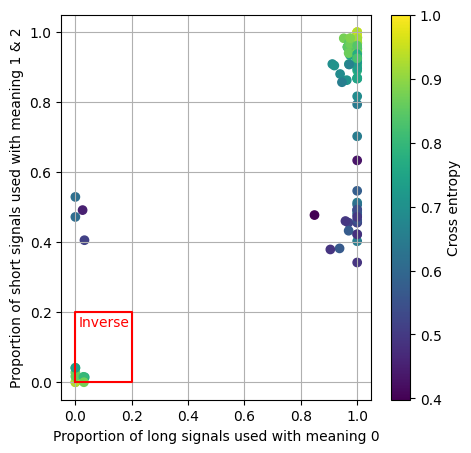

In [1067]:
plt.figure(figsize=(5, 5))
plt.scatter(results['long_0'], results['short_1'], c=results['cross_entropy'])
plt.xlabel('Proportion of long signals used with meaning 0')
plt.ylabel('Proportion of short signals used with meaning 1 & 2')
plt.grid()
# add label to colorbar saying cross entropy
plt.colorbar().set_label('Cross entropy')
# add a text to 0.2, 0.2 saying inverse in red
plt.text(0.012, 0.16, 'Inverse', color='red')
# add a square around points on 0., 0.0
plt.plot([0.0, 0.0, 0.2, 0.2, 0.0], [0.0, 0.2, 0.2, 0.0, 0.0], color='red')


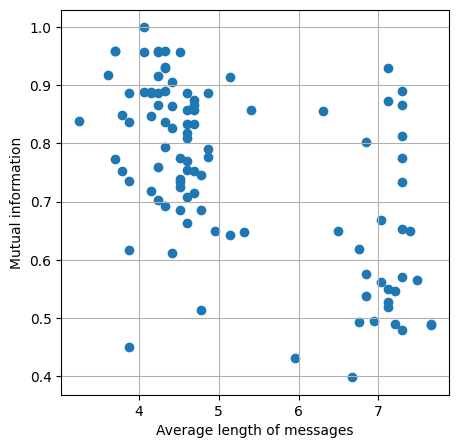

In [1068]:
plt.figure(figsize=(5, 5))
plt.scatter(results['avg_length'], results['cross_entropy'])
plt.xlabel('Average length of messages')
plt.ylabel('Mutual information')
plt.grid()

Text(33.22222222222222, 0.5, 'Message length')

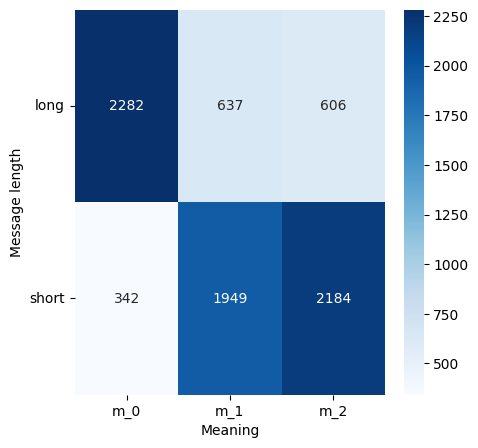

In [1069]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')
plt.figure(figsize=(5, 5))
sns.heatmap(pd.crosstab(logs_comb['message_length'], logs_comb['meaning_s']), annot=True, fmt='d', cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel('Meaning')
plt.ylabel('Message length')